**OBJECTIVE:** Assess the feasibility of building a VIMuRe model using OECD data.



**Import libraries**

In [61]:
%matplotlib inline

In [31]:
import openpyxl
import pandas as pd
import vimure as vm

# 1. The data

## 1.1 How to download the data

1. Head to OECD Stats and look for the [Balanced International Trade in Services (2005-2021)](https://stats.oecd.org/Index.aspx?DataSetCode=BATIS_EBOPS2010) data set
2. Click 'Export' then 'Related files' and click on 'Bulk download' to download a file called `OECD-WTO_BATIS_BPM6_April2023_bulk.zip`
3. Unpack the zip file to and move the unpacked files to your `data` folder. You will find two files:
    - `OECD-WTO_BATIS_BPM6_April2023_bulk.csv` (1.32 GB)
    - `OECD-WTO_BATIS_BPM6_April2023_codes.xlsx` (32 KB)

In [32]:
# Set the folder where the data is stored
DATA_FOLDER = '../../data/OECD'

batis_data_filename  = f'{DATA_FOLDER}/OECD-WTO_BATIS_BPM6_April2023_bulk.csv'

## 1.2 First contacts with the data

In [39]:
batis_df = pd.read_csv(batis_data_filename)
batis_df

,Reporter,type_Reporter,Partner,type_Partner,Flow,Item_code,type_Item,Year,Reported_value,Final_value,Methodology,Balanced_value
0,ABW,c,AFG,c,EXP,S,s,2005,NaN,0.193868,M1.3,0.098872
1,ABW,c,AFG,c,IMP,S,s,2005,NaN,0.092933,M1.4,0.069085
2,ABW,c,AFG,c,EXP,S,s,2006,NaN,0.196892,M1.3,0.104561
3,ABW,c,AFG,c,IMP,S,s,2006,NaN,0.099563,M1.4,0.074507
4,ABW,c,AFG,c,EXP,S,s,2007,NaN,0.230675,M1.3,0.116994
...,...,...,...,...,...,...,...,...,...,...,...,...
23941333,ZWE,c,ZMB,c,EXP,SPX4,d,2019,NaN,0.000000,A,0.040000
23941334,ZWE,c,ZMB,c,IMP,SPX4,d,2020,NaN,0.030000,A,0.000200
23941335,ZWE,c,ZMB,c,EXP,SPX4,d,2020,NaN,0.000000,A,0.060000
23941336,ZWE,c,ZMB,c,IMP,SPX4,d,2021,NaN,0.040000,A,0.000200


# 2. Pre-processing 

**The original data looks like this:**

In [40]:
batis_df.head()

,Reporter,type_Reporter,Partner,type_Partner,Flow,Item_code,type_Item,Year,Reported_value,Final_value,Methodology,Balanced_value
0,ABW,c,AFG,c,EXP,S,s,2005,NaN,0.193868,M1.3,0.098872
1,ABW,c,AFG,c,IMP,S,s,2005,NaN,0.092933,M1.4,0.069085
2,ABW,c,AFG,c,EXP,S,s,2006,NaN,0.196892,M1.3,0.104561
3,ABW,c,AFG,c,IMP,S,s,2006,NaN,0.099563,M1.4,0.074507
4,ABW,c,AFG,c,EXP,S,s,2007,NaN,0.230675,M1.3,0.116994


Focus on just the columns we need:

In [41]:
selected_cols = ['Reporter', 'Partner', 'Flow', 'Year', 'Final_value']
drop_cols = [col for col in batis_df.columns if col not in selected_cols]

batis_df.drop(columns=drop_cols, inplace=True)

Create `ego` and `alter` columns, [as required by VIMuRe](https://latentnetworks.github.io/vimure/latest/tutorials/R/tutorial01-data-preparation.html):

In [42]:
batis_df['ego']   = batis_df.apply(lambda x: x['Reporter'] if x['Flow'] == 'EXP' else x['Partner'], axis=1)
batis_df['alter'] = batis_df.apply(lambda x: x['Partner'] if x['Flow'] == 'EXP' else x['Reporter'], axis=1)
batis_df['layer'] = 'trade'

Rename the other columns:

In [44]:
cols_mapping = {
    'Reporter': 'reporter',
    'Flow': 'tie_type',
    'Final_value': 'weight',
    'Year': 'year'
}

batis_df.rename(columns=cols_mapping, inplace=True)

Put data frame in the same order present in the tutorials:

In [45]:
cols_order = ['ego', 'alter', 'reporter', 'tie_type', 'layer', 'weight', 'year']

batis_df = batis_df[cols_order].copy()
batis_df.head()


,ego,alter,reporter,tie_type,layer,weight,year
0,ABW,AFG,ABW,EXP,trade,0.193868,2005
1,AFG,ABW,ABW,IMP,trade,0.092933,2005
2,ABW,AFG,ABW,EXP,trade,0.196892,2006
3,AFG,ABW,ABW,IMP,trade,0.099563,2006
4,ABW,AFG,ABW,EXP,trade,0.230675,2007


# 3. High-level analysis

## 3.1 Summary Statistics

In [52]:
all_countries = set(batis_df['ego'].unique()).union(set(batis_df['alter'].unique()))
all_reporters = set(batis_df['reporter'].unique())

In [53]:
print(f"In total, there are {len(all_countries)} countries in the dataset, of which {len(all_reporters)} are reporters.")

In total, there are 209 countries in the dataset, of which 206 are reporters.


What are the countries that do not feature as reporters in the data set?

In [54]:
all_countries.difference(all_reporters)

{'E_EU', 'NOC', 'RWD'}

From the data dictionary, we get that:

| **Code**   | **Description**           |
|------------|---------------------------|
| E_EU	     | Extra-EU trade            |
| NOC        | Non-OECD member economies |
| RWD        | Rest of the world         |

## 3.2 Simple plots

<Axes: title={'center': 'Total trade flows by year and type of trade'}, xlabel='year'>

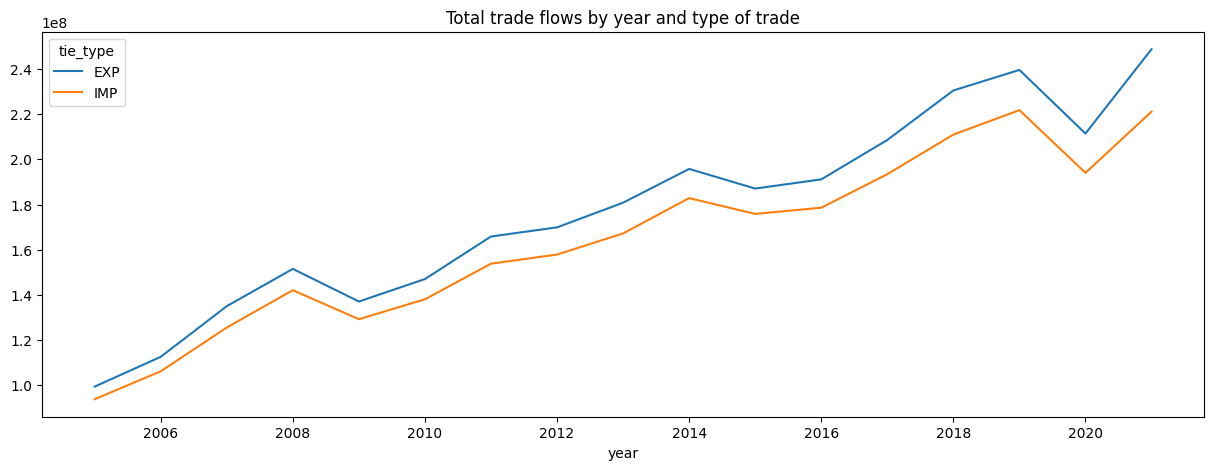

In [66]:
(batis_df.groupby(['year', 'tie_type'])['weight'].sum().unstack()
         .plot(figsize=(15, 5), title='Total trade flows by year and type of trade'))

<Axes: title={'center': 'The number of countries reporting trade flows over time is constant'}, xlabel='year'>

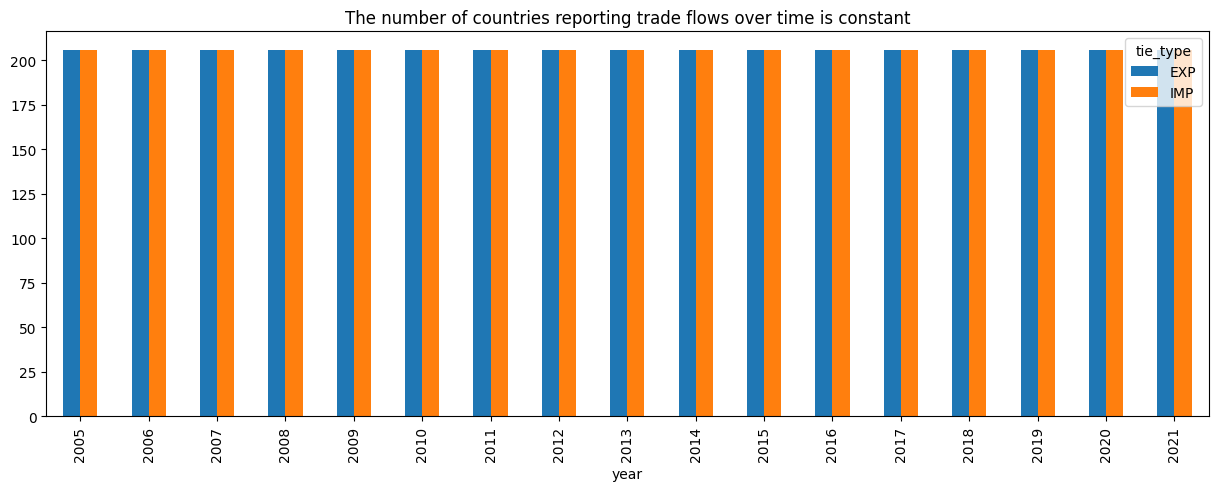

In [68]:
(batis_df.groupby(['year', 'tie_type'])['reporter'].nunique().reset_index()
         .pivot(index='year', columns='tie_type', values='reporter')
         .plot(kind='bar', stacked=False, figsize=(15, 5), 
               title='The number of countries reporting trade flows over time is constant'))

In [74]:
(batis_df.assign(self_reporter = 'self-reported' if batis_df['ego'] == batis_df['reporter'] else 'not-self-reported')
         .groupby(['year', 'ego', 'self_reporter'])['weight'].sum().unstack())

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().